In [50]:
import pulp
import time
import math
import json
import heapq
import random
import colorsys
import numpy as np
import tracemalloc
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull
from typing import List, Dict


Iniciando Simulated Annealing para o Problema de Bin Packing
Número de itens: 15
Capacidade dos bins: 1.0
--------------------------------------------------
Solução inicial: 9 bins
  Bin 0: itens [2], carga 0.40/1.0
  Bin 1: itens [12], carga 0.70/1.0
  Bin 2: itens [6], carga 0.80/1.0
  Bin 3: itens [7, 0], carga 0.70/1.0
  Bin 4: itens [8, 14], carga 0.90/1.0
  Bin 5: itens [10], carga 0.40/1.0
  Bin 6: itens [11, 5, 1], carga 0.90/1.0
  Bin 7: itens [13, 4], carga 1.00/1.0
  Bin 8: itens [3, 9], carga 0.90/1.0
Custo inicial: 9
--------------------------------------------------
Executando simulated annealing... 

>>> NOVA MELHOR SOLUÇÃO ENCONTRADA na iteração 9370 <<<
  Custo: 8
  Bin 0: itens [12], carga 0.70/1.0
  Bin 1: itens [2, 11], carga 0.50/1.0
  Bin 2: itens [1, 4, 14], carga 0.90/1.0
  Bin 3: itens [10, 8], carga 1.00/1.0
  Bin 4: itens [13], carga 0.90/1.0
  Bin 5: itens [3, 9], carga 0.90/1.0
  Bin 6: itens [6, 0], carga 1.00/1.0
  Bin 7: itens [7, 5], carga 0.80/1.0
  Ta

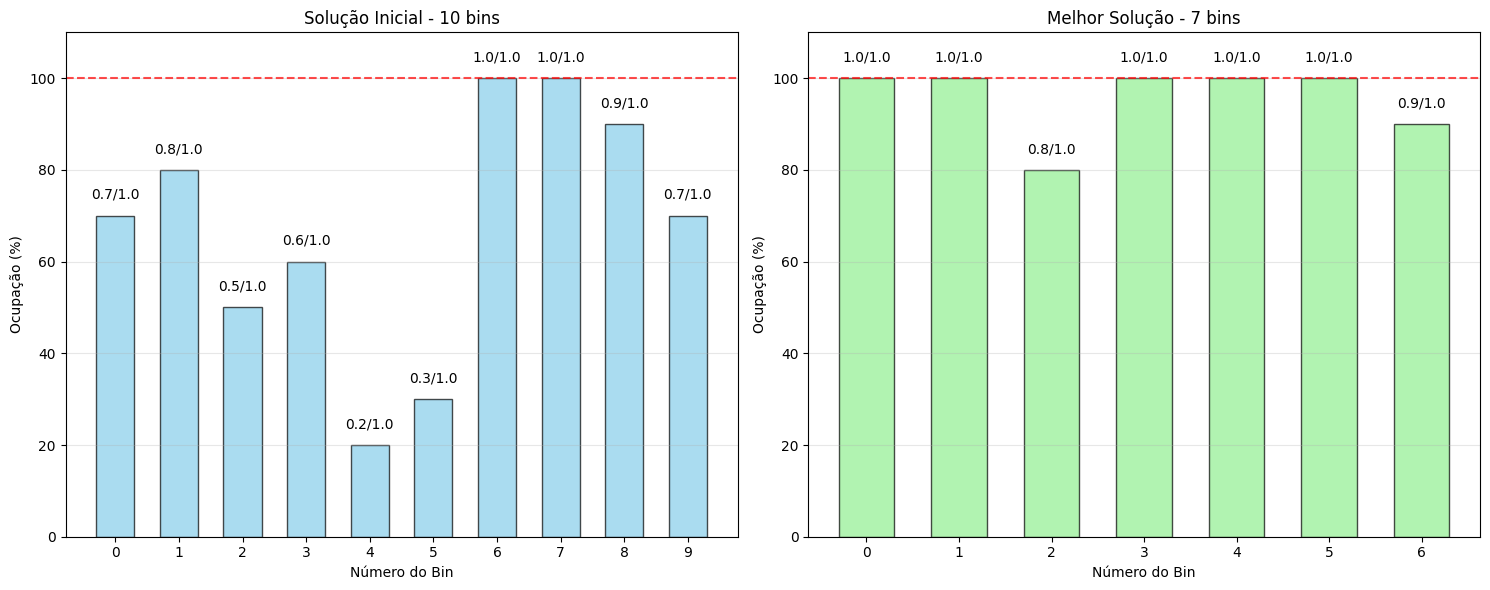

In [51]:
# QUESTÃO I: LS e SA
# Algoritmo de Simulated Annealing para o problema de Bin Packing
class BinPacking:
    @staticmethod
    def calcular_carga_bin(bin, items):
        """Calcula o peso total de um bin somando os valores de todos os itens.
        Bem simples mesmo, só pega cada item do idx e vai somando."""
        return sum(items[item_idx] for item_idx in bin)

    @staticmethod
    def imprimir_info_bins(solucao, items, c, prefixo=""):
        """Mostra no log os dados de cada bin, tipo os itens dentro dele e quanto de carga
        tá ocupando em relação à capacidade máxima. Facilita pra ver como tá a coisa."""
        for i, bin in enumerate(solucao):
            bin_load = BinPacking.calcular_carga_bin(bin, items)
            print(f"  {prefixo}Bin {i}: itens {bin}, carga {bin_load:.2f}/{c}")

    @staticmethod
    def gerar_solucao_inicial(items, c):
        """Solução inicial aleatória. Começa com cada item em um bin separado 
        e depois vai tentando juntar os itens em bins aleatórios pra ter uma 
        solução inicial que faça sentido."""
        n = len(items)
        solucao = [[i] for i in range(n)]

        for _ in range(n*2):
            if len(solucao) <= 1:
                break

            i, j = random.sample(range(len(solucao)), 2)
            carga_j = BinPacking.calcular_carga_bin(solucao[j], items)
            
            for item in solucao[i][:]:
                if carga_j + items[item] <= c:
                    solucao[j].append(item)
                    solucao[i].remove(item)
                    carga_j += items[item]

            solucao = [bin for bin in solucao if bin]
        return solucao

    @staticmethod
    def calcular_custo(solucao, items, c):
        """Avalia quanto custa a solução - no caso, quantos bins tá usando.
        Também penaliza as soluções que violam a capacidade."""
        num_bins = len(solucao)
        penalty = 0

        for bin in solucao:
            bin_load = BinPacking.calcular_carga_bin(bin, items)
            if bin_load > c:
                penalty += 100
        return num_bins + penalty

    @staticmethod
    def gerar_vizinho(solucao, items, c):
        """Explica no log qual movimento tá sendo feito - qual item tá mudando
        de lugar, de onde veio e pra onde vai, e se isso melhorou ou piorou o custo."""
        nova_solucao = [bin[:] for bin in solucao]
        if len(solucao) <= 1:
            return nova_solucao
        
        bins_nao_vazios = [i for i, bin in enumerate(nova_solucao) if bin]
        bin_origin_index = random.choice(bins_nao_vazios)
        
        item_idx = random.choice(nova_solucao[bin_origin_index])
        nova_solucao[bin_origin_index].remove(item_idx)
        
        if random.choice(["mover", "novo_bin"]) == "mover" and len(nova_solucao) > 1:
            bin_destino_candidates = [i for i in range(len(nova_solucao)) if i != bin_origin_index]
            bin_destino_index = random.choice(bin_destino_candidates)
            nova_solucao[bin_destino_index].append(item_idx)
        else:
            nova_solucao.append([item_idx])

        nova_solucao = [bin for bin in nova_solucao if bin]
        return nova_solucao

    @staticmethod
    def mostrar_movimento(solucao_atual, novo_vizinho, items, delta_custo, custo_atual, novo_custo):
        """Decide se aceita um movimento baseado no delta de custo e temperatura.
        Se melhorar, beleza, aceita. Se piorar, vai depender da temperatura - quanto
        mais quente, mais chance de aceitar mesmo piorando a solução (pra explorar mais)."""
        item_movido = None
        origem_bin = None
        destino_bin = None
        
        for i, bin in enumerate(solucao_atual):
            for item in bin:
                encontrado = False
                for j, new_bin in enumerate(novo_vizinho):
                    if item in new_bin:
                        if i != j:
                            item_movido = item
                            origem_bin = i
                            destino_bin = j
                        encontrado = True
                        break
                if not encontrado and item_movido is None:
                    item_movido = item
                    origem_bin = i
                    destino_bin = "novo bin"
                    
        if item_movido is not None:
            print(f"  Movimento: Item {item_movido} (tamanho {items[item_movido]:.2f}) movido do bin {origem_bin} para {destino_bin}")
            print(f"  Delta custo: {delta_custo} (Antes: {custo_atual}, Depois: {novo_custo})")

    @staticmethod
    def decidir_aceitacao(delta_custo, temp):
        """Quando acha uma solução melhor que todas as anteriores, mostra ela na tela e
        guarda no histórico. Somente pra acompanhar o progresso do processo."""
        if delta_custo <= 0:
            return True, "movimento melhorou ou manteve o custo"
        
        probabilidade = math.exp(-delta_custo / temp)
        if random.random() < probabilidade:
            return True, f"movimento piorou mas foi aceito com probabilidade {probabilidade:.4f}"
        
        return False, f"movimento piorou e foi rejeitado (prob. aceitação: {probabilidade:.4f})"

    @staticmethod
    def registrar_nova_melhor_solucao(iteracoes, melhor_custo, melhor_solucao, items, c, 
                                aceitos, aceitos_piores, temp, melhores_solucoes_log):
        print(f"\n>>> NOVA MELHOR SOLUÇÃO ENCONTRADA na iteração {iteracoes} <<<")
        print(f"  Custo: {melhor_custo}")
        BinPacking.imprimir_info_bins(melhor_solucao, items, c)
        print(f"  Taxa de aceitação: {aceitos/iteracoes:.2%} (geral), {aceitos_piores/(iteracoes-aceitos+1):.2%} (movimentos piores)")
        print("-" * 50)
        
        melhores_solucoes_log.append({
            'iteracao': iteracoes,
            'custo': melhor_custo,
            'solucao': [bin[:] for bin in melhor_solucao],
            'temperatura': temp
        })

    @staticmethod
    def imprimir_resultados_finais(melhor_solucao, melhor_custo, items, c, iteracoes, 
                            aceitos, aceitos_piores, tempo_total, melhores_solucoes_log):
        """Um resumão de finish com as principais informações."""
        print("\nResultados finais:")
        print(f"Melhor solução encontrada (custo {melhor_custo}):")
        BinPacking.imprimir_info_bins(melhor_solucao, items, c)
        print(f"Total de iterações: {iteracoes}")
        print(f"Movimentos aceitos: {aceitos} ({aceitos/iteracoes:.2%})")
        print(f"Movimentos piores aceitos: {aceitos_piores} ({aceitos_piores/(iteracoes-aceitos+1):.2%} do total)")
        print(f"Tempo total: {tempo_total:.2f} segundos")
        
        print("\nEvolução das melhores soluções:")
        for i, log in enumerate(melhores_solucoes_log):
            print(f"{i+1}. Iteração {log['iteracao']}: {log['custo']} bins (T={log['temperatura']:.2f})")

    @staticmethod
    def simulated_annealing(items, c, tempo_limite=1000, tempo_inicial=10000, taxa_resfriamento=0.95, verbose=True):
        """Função principal que implementa o simulated annealing.
        Começa com uma solução aleatória e vai testando vizinhos, aceitando ou não
        dependendo da temperatura (que temtendência de caída sempre). Roda até bater o tempo limite, caso seja necessário."""
        tempo_inicio = time.time()

        solucao_atual = BinPacking.gerar_solucao_inicial(items, c)
        custo_atual = BinPacking.calcular_custo(solucao_atual, items, c)

        if verbose:
            print(f"Solução inicial: {len(solucao_atual)} bins")
            BinPacking.imprimir_info_bins(solucao_atual, items, c)
            print(f"Custo inicial: {custo_atual}")
            print("-" * 50)
            print("Executando simulated annealing... ")

        melhor_solucao = [bin[:] for bin in solucao_atual]
        melhor_custo = custo_atual

        temp = tempo_inicial
        historico_custos = [custo_atual]
        iteracoes = 0
        aceitos = 0
        aceitos_piores = 0
        melhores_solucoes_log = []

        # Log controller
        intervalo_log = 100000

        while time.time() - tempo_inicio < tempo_limite:
            iteracoes += 1
            
            if verbose and iteracoes % intervalo_log == 0:
                print(f"\nIteração {iteracoes}:")
                print(f"  Temperatura atual: {temp:.2f}")
                
            novo_vizinho = BinPacking.gerar_vizinho(solucao_atual, items, c)
            novo_custo = BinPacking.calcular_custo(novo_vizinho, items, c)
            delta_custo = novo_custo - custo_atual

            if verbose and iteracoes % intervalo_log == 0:
                BinPacking.mostrar_movimento(solucao_atual, novo_vizinho, items, delta_custo, custo_atual, novo_custo)

            aceitar, razao = BinPacking.decidir_aceitacao(delta_custo, temp)
            
            if verbose and iteracoes % intervalo_log == 0:
                print(f"  Decisão: {razao}")
                
            if aceitar:
                if delta_custo <= 0:
                    aceitos += 1
                else:
                    aceitos_piores += 1
                    
                solucao_atual = novo_vizinho
                custo_atual = novo_custo

                if custo_atual < melhor_custo:
                    melhor_solucao = [bin[:] for bin in solucao_atual]
                    melhor_custo = custo_atual
                    
                    if verbose:
                        BinPacking.registrar_nova_melhor_solucao(iteracoes, melhor_custo, melhor_solucao, 
                                                items, c, aceitos, aceitos_piores, temp, 
                                                melhores_solucoes_log)

            if iteracoes % 10 == 0:
                historico_custos.append(custo_atual)
            if iteracoes % 100 == 0:
                temp *= taxa_resfriamento

        tempo_total = time.time() - tempo_inicio
        if verbose:
            BinPacking.imprimir_resultados_finais(melhor_solucao, melhor_custo, items, c, iteracoes, 
                                    aceitos, aceitos_piores, tempo_total, 
                                    melhores_solucoes_log)

        return {
            'melhor_solucao': melhor_solucao,
            'melhor_custo': melhor_custo,
            'iteracoes': iteracoes,
            'tempo_total': tempo_total,
            'historico_custos': historico_custos,
            'melhores_solucoes_log': melhores_solucoes_log,
            'aceitos': aceitos,
            'aceitos_piores': aceitos_piores
        }

    @staticmethod
    def comparar_solucoes_inicial_final(solucao_inicial, melhor_solucao, items, c):
        """Aqui são só os Plots de saída, com solução inicial e final, facilitar 
        visualização da melhora que conseguimos"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        for i, bin in enumerate(solucao_inicial):
            bin_load = BinPacking.calcular_carga_bin(bin, items)
            ocupacao = bin_load / c * 100
            
            ax1.bar(i, ocupacao, width=0.6, 
                    color='skyblue' if bin_load <= c else 'red',
                    edgecolor='black', alpha=0.7)
            
            ax1.text(i, ocupacao + 3, f"{bin_load:.1f}/{c}", 
                    ha='center', va='bottom')
        
        ax1.set_title(f"Solução Inicial - {len(solucao_inicial)} bins")
        ax1.set_xlabel("Número do Bin")
        ax1.set_ylabel("Ocupação (%)")
        ax1.axhline(y=100, color='r', linestyle='--', alpha=0.7)
        ax1.set_ylim(0, 110)
        ax1.set_xticks(range(len(solucao_inicial)))
        ax1.grid(axis='y', alpha=0.3)
        
        for i, bin in enumerate(melhor_solucao):
            bin_load = BinPacking.calcular_carga_bin(bin, items)
            ocupacao = bin_load / c * 100
            
            ax2.bar(i, ocupacao, width=0.6, 
                    color='lightgreen' if bin_load <= c else 'red',
                    edgecolor='black', alpha=0.7)
            
            ax2.text(i, ocupacao + 3, f"{bin_load:.1f}/{c}", 
                    ha='center', va='bottom')
        
        ax2.set_title(f"Melhor Solução - {len(melhor_solucao)} bins")
        ax2.set_xlabel("Número do Bin")
        ax2.set_ylabel("Ocupação (%)")
        ax2.axhline(y=100, color='r', linestyle='--', alpha=0.7)
        ax2.set_ylim(0, 110)
        ax2.set_xticks(range(len(melhor_solucao)))
        ax2.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()


# Simulated de pesos/quantia-items aqui
items = [0.2, 0.5, 0.4, 0.7, 0.1, 0.3, 0.8, 0.5, 0.6, 0.2, 0.4, 0.1, 0.7, 0.9, 0.3]
capacidade = 1.0

print("Iniciando Simulated Annealing para o Problema de Bin Packing")
print(f"Número de itens: {len(items)}")
print(f"Capacidade dos bins: {capacidade}")
print("-" * 50)

solucao_inicial = BinPacking.gerar_solucao_inicial(items, capacidade)
resultado = BinPacking.simulated_annealing(items, capacidade, tempo_limite=50, verbose=True)

print(f"\nRESUMO FINAL:")
print(f"Número de bins necessários: {resultado['melhor_custo']}")
print(f"Tempo total de execução: {resultado['tempo_total']:.2f} segundos")
print(f"Iterações realizadas: {resultado['iteracoes']}")
print(f"Taxa de aceitação de movimentos: {resultado['aceitos']/resultado['iteracoes']:.2%}")

BinPacking.comparar_solucoes_inicial_final(solucao_inicial, resultado['melhor_solucao'], items, capacidade)

Cada cell representa um problema, que pode conter mais de um método para buscar o espaço de solução ótima.

Iniciando Iterações GLS. Você não verá esse log.


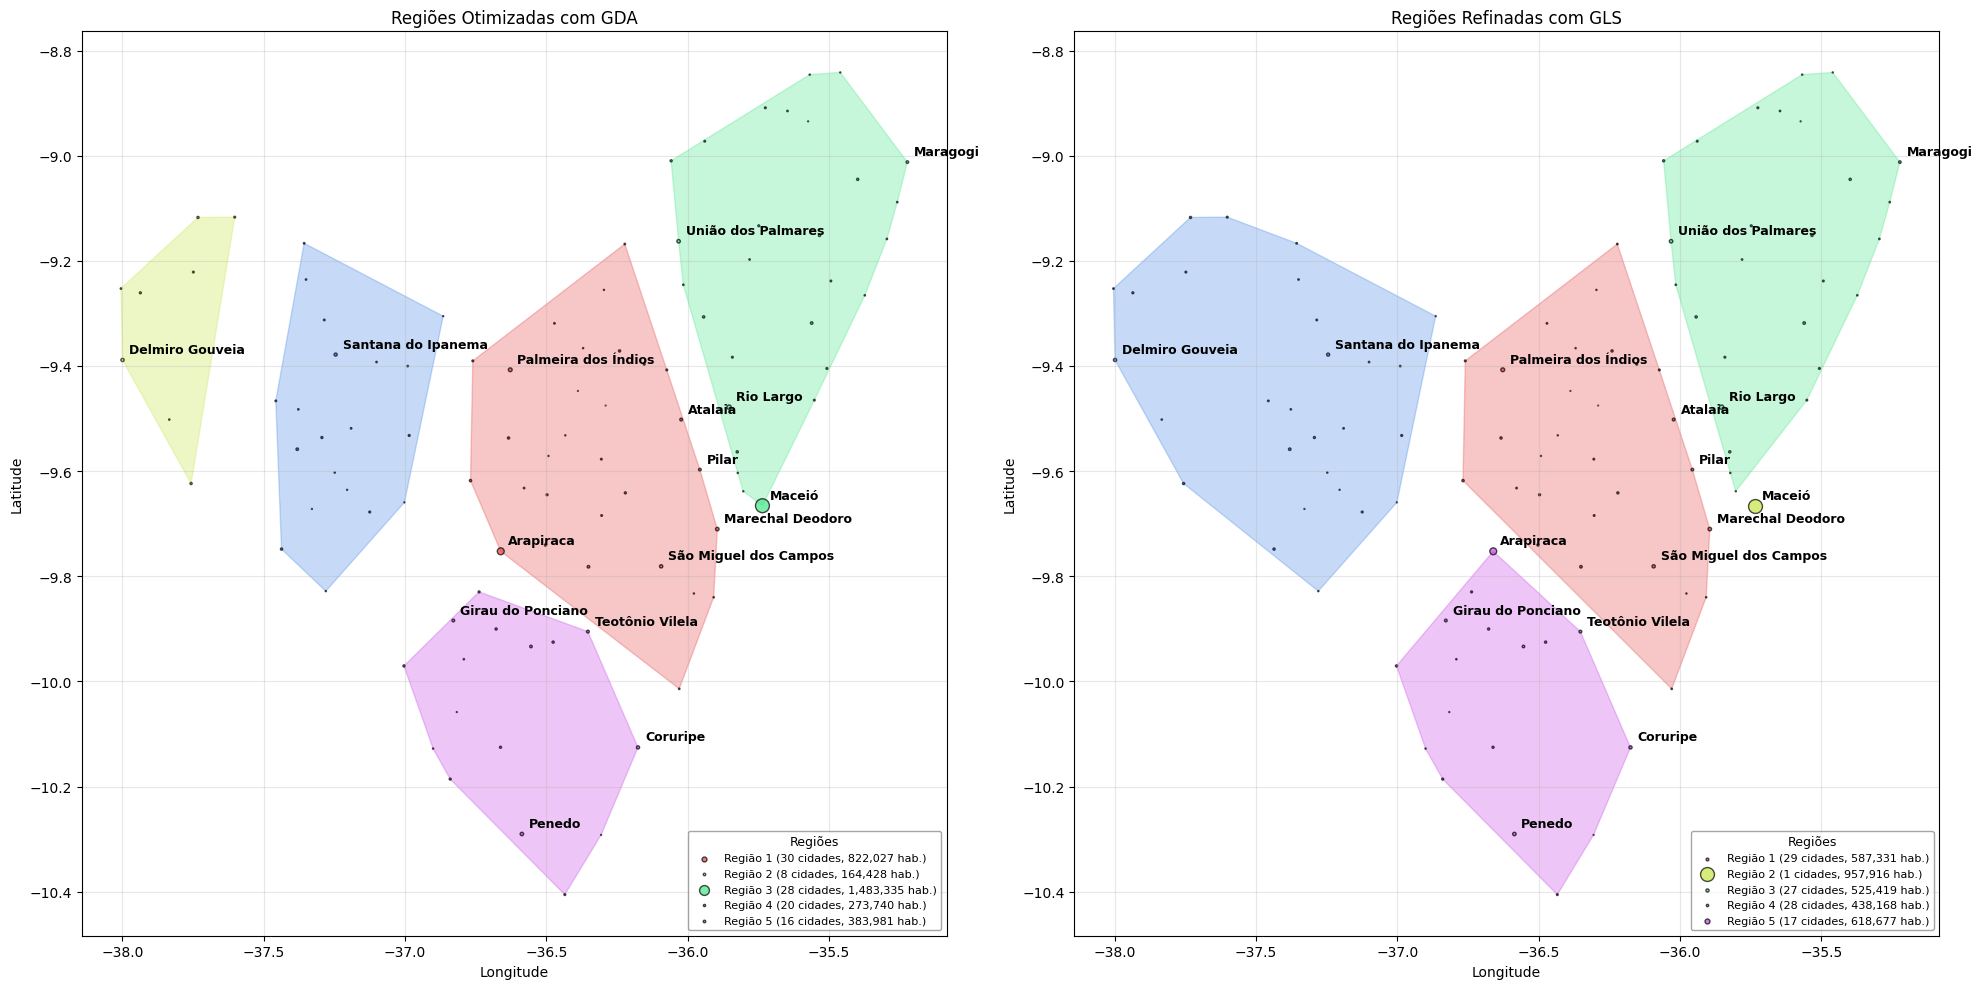

In [ ]:
# QUESTÃO II
# Problema das formas - Análise e agrupamento espacial de cidades
# Métodos utilizados: GDA (Guloso) e GLS (Busca Local Guiada)

class ProblemaFormas:
    def __init__(self, arquivo_cidades='cities-al.json'):
        """Inicializa o problema das formas usando dados das cidades de Alagoas."""
        with open(arquivo_cidades, 'r') as f:
            self.cidades = json.load(f)

        self.pontos = np.array([[cidade['latitude'], cidade['longitude']] for cidade in self.cidades])
        self.nomes = [cidade['municipio'] for cidade in self.cidades]
        self.populacao = np.array([cidade['populacao'] for cidade in self.cidades])
        self.pop_normalizada = 100 * self.populacao / max(self.populacao)

    def _gerar_cores(self, n):
        """Gera uma paleta de cores para os clusters."""
        cores = []
        for i in range(n):
            hue = i / n
            r, g, b = colorsys.hsv_to_rgb(hue, 0.7, 0.9)
            cores.append((r, g, b))
        return cores

    def gda_regionalizacao(self, n_regioes=5, criterio='compacidade'):
        """Aplica o algoritmo guloso para regionalizar as cidades."""
        num_cidades = len(self.pontos)
        cidades_nao_alocadas = set(range(num_cidades))
        clusters = np.full(num_cidades, -1)

        # Calcula distâncias entre as cidades (matriz)
        matriz_dist = np.zeros((num_cidades, num_cidades))
        for i in range(num_cidades):
            for j in range(i + 1, num_cidades):
                dist = np.linalg.norm(self.pontos[i] - self.pontos[j])
                matriz_dist[i, j] = matriz_dist[j, i] = dist

        # Seleção de sementes (são os pontos iniciais, cada região)
        if criterio == 'balanceamento':
            sementes = np.argsort(self.populacao)[-n_regioes:]  # cidades mais populosas
        else:
            sementes = []
            centro = np.mean(self.pontos, axis=0)
            dist_ao_centro = np.sum((self.pontos - centro) ** 2, axis=1)
            sementes.append(np.argmin(dist_ao_centro))  # cidade mais próxima do centroide

            while len(sementes) < n_regioes:
                dist_min = []
                for i in range(num_cidades):
                    if i not in sementes:
                        dist_a_sementes = [matriz_dist[i, s] for s in sementes]
                        dist_min.append((i, min(dist_a_sementes)))
                prox = max(dist_min, key=lambda x: x[1])[0]
                sementes.append(prox)

        for i, semente in enumerate(sementes):
            clusters[semente] = i
            cidades_nao_alocadas.remove(semente)

        def calcular_beneficio(cidade, regiao, regioes_atuais):
            """Avalia o benefício de alocar uma cidade a uma região."""
            pontos_regiao = self.pontos[regioes_atuais == regiao]
            if len(pontos_regiao) > 0:
                centroide = np.mean(pontos_regiao, axis=0)
                dist = np.linalg.norm(self.pontos[cidade] - centroide)
                beneficio = 1.0 / (1.0 + dist)

                if criterio == 'balanceamento':
                    pop_regiao = sum(self.populacao[regioes_atuais == regiao])
                    pop_total = pop_regiao + self.populacao[cidade]
                    pop_media = np.sum(self.populacao) / n_regioes
                    fator_pop = 1.0 / (1.0 + abs(pop_total - pop_media) / pop_media)
                    beneficio *= fator_pop

                return beneficio
            return 0

        while cidades_nao_alocadas:
            melhor, maior_beneficio = None, -np.inf
            for cidade in cidades_nao_alocadas:
                for regiao in range(n_regioes):
                    beneficio = calcular_beneficio(cidade, regiao, clusters)
                    if beneficio > maior_beneficio:
                        maior_beneficio = beneficio
                        melhor = (cidade, regiao)
            clusters[melhor[0]] = melhor[1]
            cidades_nao_alocadas.remove(melhor[0])
        return clusters

    def gls_regionalizacao(self, clusters_iniciais, max_iter, lambda_penalidade=0.1):
        """Refina os clusters com Busca Local Guiada por Penalidades (GLS)."""
        print("Iniciando Iterações GLS. Você não verá esse log.")
        n_cidades = len(self.pontos)
        n_regioes = len(np.unique(clusters_iniciais))

        melhor_solucao = clusters_iniciais.copy()
        solucao_atual = clusters_iniciais.copy()
        penalidades = np.zeros((n_cidades, n_regioes))

        def calcular_custo(solucao, penalidades=None):
            """Calcula o custo de uma solução de regionalização."""
            custo_base, custo_penalidade = 0, 0
            for regiao in range(n_regioes):
                mask = solucao == regiao
                if np.sum(mask) == 0:
                    continue
                pontos = self.pontos[mask]
                centroide = np.mean(pontos, axis=0)
                dispersao = np.sum([np.linalg.norm(p - centroide) for p in pontos])
                pop_regiao = np.sum(self.populacao[mask])
                pop_media = np.sum(self.populacao) / n_regioes
                desequilibrio = abs(pop_regiao - pop_media) / pop_media
                custo_base += dispersao + desequilibrio * 1000
                if penalidades is not None:
                    custo_penalidade += lambda_penalidade * np.sum(penalidades[mask, regiao])
            return custo_base + custo_penalidade

        melhor_custo = calcular_custo(melhor_solucao)

        # Busca local com a realocação das cidades
        for iteracao in range(max_iter):
            melhorou = True
            while melhorou:
                melhorou = False
                for cidade in range(n_cidades):
                    atual = solucao_atual[cidade]
                    for nova in range(n_regioes):
                        if nova == atual:
                            continue
                        teste = solucao_atual.copy()
                        teste[cidade] = nova
                        if calcular_custo(teste, penalidades) < calcular_custo(solucao_atual, penalidades):
                            solucao_atual = teste
                            melhorou = True
                            custo_sem_penalidade = calcular_custo(solucao_atual)
                            if custo_sem_penalidade < melhor_custo:
                                melhor_solucao = solucao_atual.copy()
                                melhor_custo = custo_sem_penalidade
                            break
                    if melhorou:
                        break

            # Aplicação de penalidades
            if not melhorou:
                for regiao in range(n_regioes):
                    mask = solucao_atual == regiao
                    if np.sum(mask) == 0:
                        continue
                    pontos = self.pontos[mask]
                    centroide = np.mean(pontos, axis=0)
                    mais_distante = max(np.where(mask)[0],
                                        key=lambda i: np.linalg.norm(self.pontos[i] - centroide) * (1 + penalidades[i, regiao]),
                                        default=None)
                    if mais_distante is not None:
                        penalidades[mais_distante, regiao] += 1
        return melhor_solucao

    def visualizar_comparacao(self, clusters_gda, clusters_gls, n_regioes):
        """Visualiza os dois conjuntos de clusters lado a lado."""
        cores = self._gerar_cores(n_regioes)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        
        # Primeira visualização (GDA)
        for i in range(n_regioes):
            mask = clusters_gda == i
            pontos = self.pontos[mask]
            if len(pontos) >= 3:
                hull = ConvexHull(pontos)
                poly = Polygon(pontos[hull.vertices][:, [1, 0]], alpha=0.3, color=cores[i])
                ax1.add_patch(poly)
            ax1.scatter(pontos[:, 1], pontos[:, 0], s=self.pop_normalizada[mask],
                       color=cores[i], edgecolors='k', alpha=0.7,
                       label=f'Região {i+1} ({np.sum(mask)} cidades, {np.sum(self.populacao[mask]):,} hab.)')

        for i, (nome, pop, coord) in enumerate(zip(self.nomes, self.populacao, self.pontos)):
            if pop > np.percentile(self.populacao, 85):
                ax1.annotate(nome, (coord[1], coord[0]), xytext=(5, 5),
                            textcoords="offset points", fontsize=9, fontweight='bold')

        ax1.set_title(f'Regiões Otimizadas com GDA')
        ax1.set_xlabel('Longitude')
        ax1.set_ylabel('Latitude')
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc='lower right', framealpha=0.7, facecolor='white', edgecolor='gray', 
                  fontsize=8, title_fontsize=9, title='Regiões')
        
        # Segunda visualização (GLS)
        for i in range(n_regioes):
            mask = clusters_gls == i
            pontos = self.pontos[mask]
            if len(pontos) >= 3:
                hull = ConvexHull(pontos)
                poly = Polygon(pontos[hull.vertices][:, [1, 0]], alpha=0.3, color=cores[i])
                ax2.add_patch(poly)
            ax2.scatter(pontos[:, 1], pontos[:, 0], s=self.pop_normalizada[mask],
                       color=cores[i], edgecolors='k', alpha=0.7,
                       label=f'Região {i+1} ({np.sum(mask)} cidades, {np.sum(self.populacao[mask]):,} hab.)')

        for i, (nome, pop, coord) in enumerate(zip(self.nomes, self.populacao, self.pontos)):
            if pop > np.percentile(self.populacao, 85):
                ax2.annotate(nome, (coord[1], coord[0]), xytext=(5, 5),
                            textcoords="offset points", fontsize=9, fontweight='bold')

        ax2.set_title('Regiões Refinadas com GLS')
        ax2.set_xlabel('Longitude')
        ax2.set_ylabel('Latitude')
        ax2.grid(True, alpha=0.3)
        ax2.legend(loc='lower right', framealpha=0.7, facecolor='white', edgecolor='gray', 
                  fontsize=8, title_fontsize=9, title='Regiões')
        
        plt.tight_layout()
        plt.show()

    def _visualizar_clusters(self, clusters, n_regioes, titulo):
        """Visualiza os clusters formados com regiões em mapa geográfico."""
        cores = self._gerar_cores(n_regioes)
        fig, ax = plt.subplots(figsize=(12, 10))

        for i in range(n_regioes):
            mask = clusters == i
            pontos = self.pontos[mask]
            if len(pontos) >= 3:
                hull = ConvexHull(pontos)
                poly = Polygon(pontos[hull.vertices][:, [1, 0]], alpha=0.3, color=cores[i])
                ax.add_patch(poly)
            ax.scatter(pontos[:, 1], pontos[:, 0], s=self.pop_normalizada[mask],
                       color=cores[i], edgecolors='k', alpha=0.7,
                       label=f'Região {i+1} ({np.sum(mask)} cidades, {np.sum(self.populacao[mask]):,} hab.)')

        for i, (nome, pop, coord) in enumerate(zip(self.nomes, self.populacao, self.pontos)):
            if pop > np.percentile(self.populacao, 85):
                ax.annotate(nome, (coord[1], coord[0]), xytext=(5, 5),
                            textcoords="offset points", fontsize=9, fontweight='bold')

        ax.set_title(titulo)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='lower right', framealpha=0.7, facecolor='white', edgecolor='gray', 
                  fontsize=8, title_fontsize=9, title='Regiões')
        plt.tight_layout()
        plt.show()

# Params and call
problema = ProblemaFormas('cities-al.json')
k_otimo = 5
clusters_gda = problema.gda_regionalizacao(n_regioes=k_otimo, criterio='compacidade')
clusters_gls = problema.gls_regionalizacao(clusters_gda, max_iter=10)
problema.visualizar_comparacao(clusters_gda, clusters_gls, k_otimo)

Geração 1: Melhor lucro = R$ 3286088.85
Geração 2: Melhor lucro = R$ 3286088.85
Geração 3: Melhor lucro = R$ 3286088.85
Geração 4: Melhor lucro = R$ 3286088.85
Geração 5: Melhor lucro = R$ 3286088.85
Geração 6: Melhor lucro = R$ 3286088.85
Geração 7: Melhor lucro = R$ 3286088.85
Geração 8: Melhor lucro = R$ 3286088.85
Geração 9: Melhor lucro = R$ 3286088.85
Geração 10: Melhor lucro = R$ 3286088.85
Geração 11: Melhor lucro = R$ 3286088.85
Geração 12: Melhor lucro = R$ 3286088.85
Geração 13: Melhor lucro = R$ 3286088.85
Geração 14: Melhor lucro = R$ 3286088.85
Geração 15: Melhor lucro = R$ 3286088.85
Geração 16: Melhor lucro = R$ 3286088.85
Geração 17: Melhor lucro = R$ 3286088.85
Geração 18: Melhor lucro = R$ 3286088.85
Geração 19: Melhor lucro = R$ 3286088.85
Geração 20: Melhor lucro = R$ 3286088.85
Geração 21: Melhor lucro = R$ 3286088.85
Geração 22: Melhor lucro = R$ 3286088.85
Geração 23: Melhor lucro = R$ 3286088.85
Geração 24: Melhor lucro = R$ 3286088.85
Geração 25: Melhor lucro 

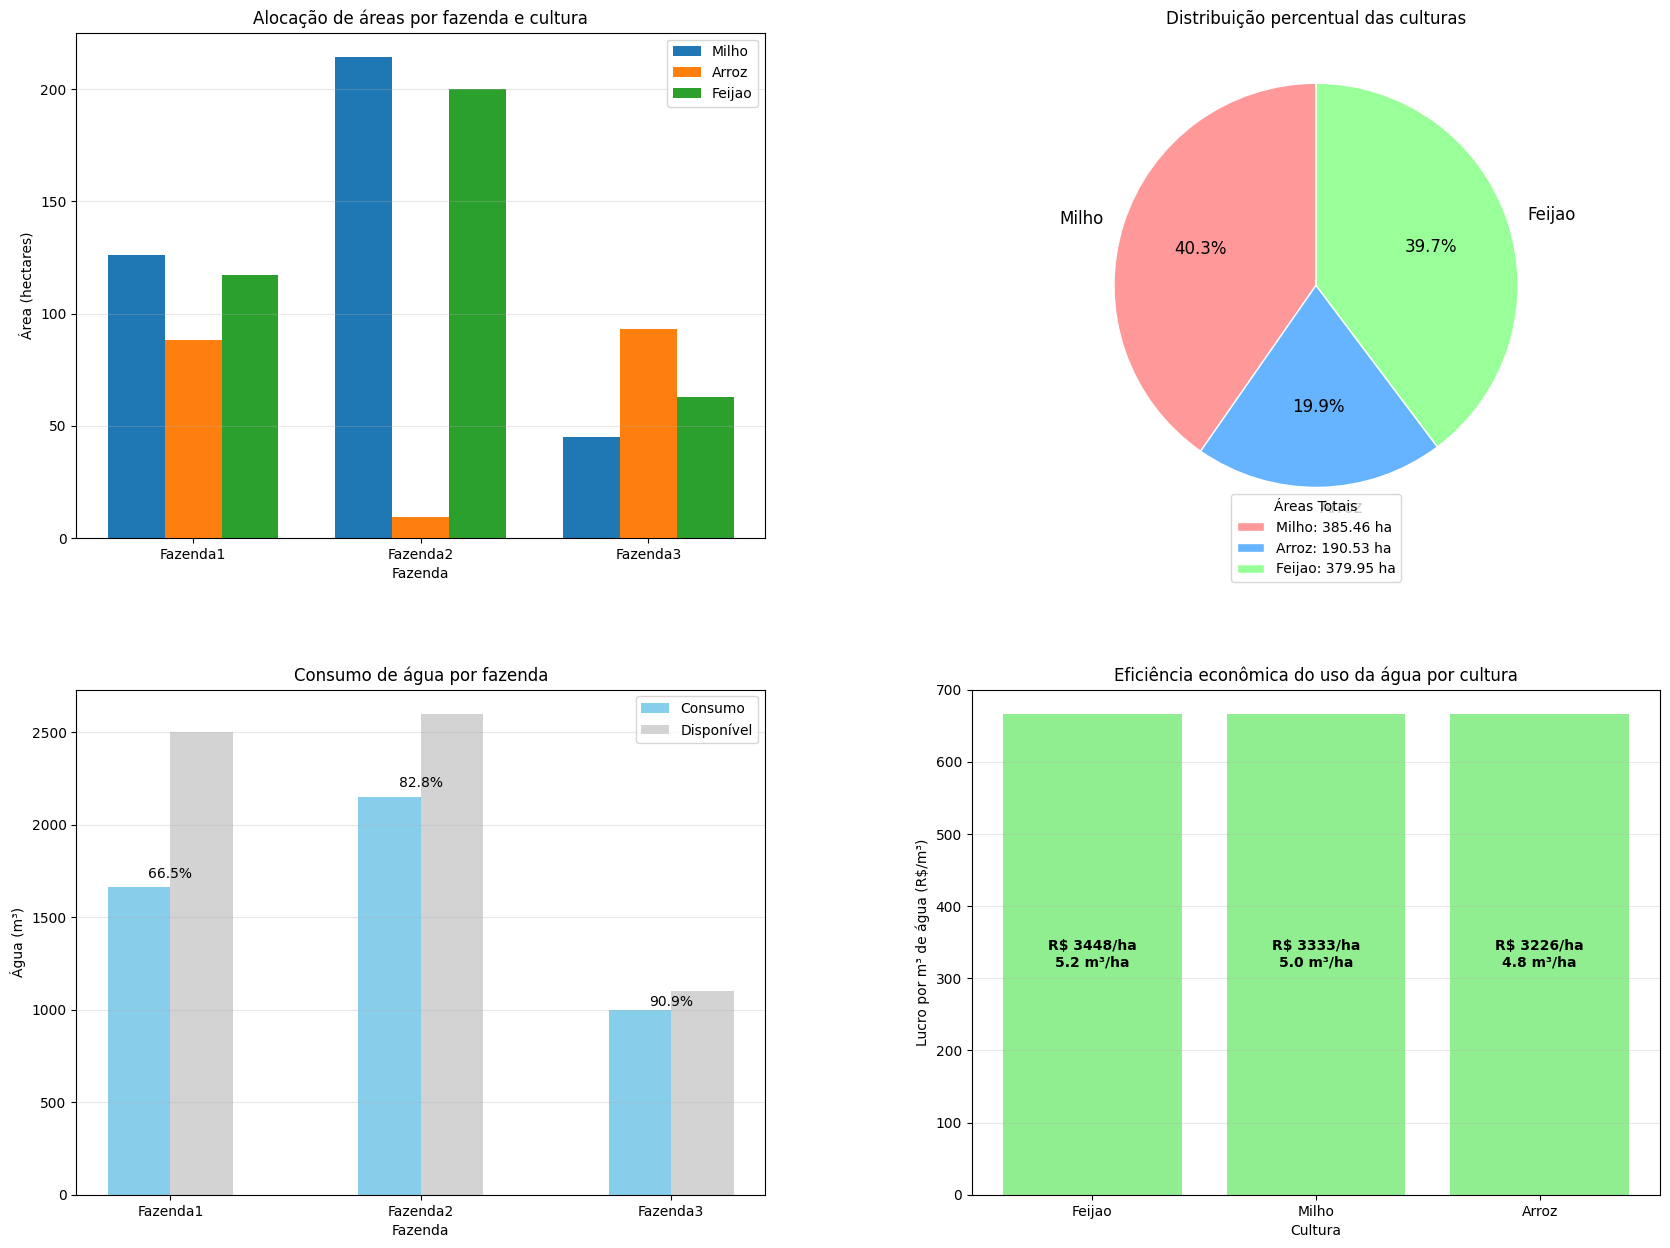

In [91]:
# QUESTÃO II
# Problema do plantio 
# Método utilizado: Algoritmo Genético (GA)

class ProblemaPlantio:
    
    @staticmethod
    def resolver_com_ga(pop_size, max_generations, mutation_rate, crossover_rate, verbose=True):
        """Resolve o problema do plantio usando Algoritmo Genético (GA)."""
        
        fazendas = ["Fazenda1", "Fazenda2", "Fazenda3"]
        culturas = ["Milho", "Arroz", "Feijao"]
        
        area_fazenda = {
            "Fazenda1": 400,
            "Fazenda2": 650,
            "Fazenda3": 350
        }
        
        agua_fazenda = {
            "Fazenda1": 2500,
            "Fazenda2": 2600,
            "Fazenda3": 1100
        }
        
        area_max_cultura = {
            "Milho": 600,
            "Arroz": 620,
            "Feijao": 580
        }
        
        area_min_cultura = {
            "Milho": 60,
            "Arroz": 62,
            "Feijao": 58
        }
        
        agua_por_area = {
            "Milho": 5.00,
            "Arroz": 4.84,
            "Feijao": 5.17
        }
        
        lucro_por_area = {
            "Milho": 3333,
            "Arroz": 3226,
            "Feijao": 3448
        }
        
        # Função para calcular o lucro total
        def calcular_lucro(solucao):
            lucro_base = 0
            for f in fazendas:
                for c in culturas:
                    lucro_base += solucao[f][c] * lucro_por_area[c]
            
            # Calcular métricas de diversidade
            area_por_cultura = {c: sum(solucao[f][c] for f in fazendas) for c in culturas}
            area_total = sum(area_por_cultura.values())
                
            # Calcular quanto cada cultura contribui para o total
            proporções = {c: area_por_cultura[c] / area_total for c in culturas}
            maior_proporcao = max(proporções.values()) if proporções else 0
            menor_proporcao = min(proporções.values()) if proporções else 0
            
            # Calcular o bônus/penalidade de diversidade
            if maior_proporcao > 0.7:  # Uma cultura tem mais de 70% da área total
                penalidade = 0.03 * (maior_proporcao - 0.7) * lucro_base  # Penaliza proporcionalmente ao desequilíbrio
                return lucro_base - penalidade
            elif menor_proporcao < 0.1:
                penalidade = 0.02 * (0.1 - menor_proporcao) * lucro_base
                return lucro_base - penalidade
            else:
                # Recompensar/equilibrar
                balanceamento = 1 - (maior_proporcao - menor_proporcao)  # Quanto mais próximo de 1, mais equilibrado
                bonus = 0.03 * balanceamento * lucro_base
                return lucro_base + bonus
        
        # Função para verificar se uma solução é viável
        def verificar_viabilidade(solucao):
            for f in fazendas:
                if sum(solucao[f][c] for c in culturas) > area_fazenda[f]:
                    return False
            
            for f in fazendas:
                agua_usada = sum(solucao[f][c] * agua_por_area[c] for c in culturas)
                if agua_usada > agua_fazenda[f]:
                    return False
            
            for c in culturas:
                if sum(solucao[f][c] for f in fazendas) > area_max_cultura[c]:
                    return False
            
            for c in culturas:
                if sum(solucao[f][c] for f in fazendas) < area_min_cultura[c]:
                    return False
            
            return True
        
        # Função para gerar uma solução inicial aleatória
        def gerar_solucao():
            solucao = {f: {c: random.uniform(0, area_fazenda[f] / len(culturas)) for c in culturas} for f in fazendas}
            return solucao
        
        # Função para realizar o crossover entre duas soluções
        def crossover(solucao1, solucao2):
            nova_solucao = {f: {c: (solucao1[f][c] + solucao2[f][c]) / 2 for c in culturas} for f in fazendas}
            return nova_solucao
        
        # Função para realizar a mutação em uma solução
        def mutacao(solucao):
            f = random.choice(fazendas)
            c1, c2 = random.sample(culturas, 2)
            delta = random.uniform(0, solucao[f][c1] * mutation_rate)
            solucao[f][c1] -= delta
            solucao[f][c2] += delta
        
        # Função para criar a população inicial
        def criar_populacao():
            return [gerar_solucao() for _ in range(pop_size)]
        
        # Função para selecionar os pais (torneio)
        def selecionar_pais(populacao):
            return random.sample(populacao, 2)
        
        # Algoritmo Genético
        populacao = criar_populacao()
        melhor_solucao = None
        melhor_lucro = float('-inf')
        
        for geracao in range(max_generations):
            nova_populacao = []
            
            for _ in range(pop_size // 2):
                pai1, pai2 = selecionar_pais(populacao)
                if random.random() < crossover_rate:
                    filho1 = crossover(pai1, pai2)
                    filho2 = crossover(pai2, pai1)
                else:
                    filho1, filho2 = pai1, pai2
                
                if random.random() < mutation_rate:
                    mutacao(filho1)
                if random.random() < mutation_rate:
                    mutacao(filho2)
                
                if verificar_viabilidade(filho1):
                    nova_populacao.append(filho1)
                if verificar_viabilidade(filho2):
                    nova_populacao.append(filho2)
            
            populacao = nova_populacao
            
            # Avaliar a população
            for solucao in populacao:
                lucro = calcular_lucro(solucao)
                if lucro > melhor_lucro:
                    melhor_solucao = solucao
                    melhor_lucro = lucro
            
            if verbose:
                print(f"Geração {geracao + 1}: Melhor lucro = R$ {melhor_lucro:.2f}")
        
        # Retornar os resultados
        plantio_vars = {}
        for f in fazendas:
            plantio_vars[f] = {}
            for c in culturas:
                var = pulp.LpVariable(f"{f}_{c}", lowBound=0, cat='Continuous')
                var.varValue = melhor_solucao[f][c]
                plantio_vars[f][c] = var
        
        return {
            'status': "Optimal (GA)",
            'plantio_vars': plantio_vars,
            'lucro_total': melhor_lucro,
            'area_fazenda': area_fazenda,
            'agua_fazenda': agua_fazenda,
            'fazendas': fazendas,
            'culturas': culturas,
            'area_max_cultura': area_max_cultura,
            'area_min_cultura': area_min_cultura,
            'agua_por_area': agua_por_area,
            'lucro_por_area': lucro_por_area
        }
    
    @staticmethod
    def mostrar_resultados(resultado):
        """Exibe os resultados detalhados da solução encontrada pelo VNS."""
        print("\nResultados da otimização do plantio:")
        print(f"Status: {resultado['status']}")
        print(f"Lucro total: R$ {resultado['lucro_total']:.2f}")
        
        print("\nÁreas alocadas por fazenda e cultura (em hectares):")
        print(f"{'Fazenda':<10} {'Milho':<10} {'Arroz':<10} {'Feijao':<10} {'Total':<10} {'% Utilização':<15}")
        print("-" * 65)
        
        for f in resultado['fazendas']:
            area_total_f = sum(resultado['plantio_vars'][f][c].varValue for c in resultado['culturas'])
            utilizacao = area_total_f / resultado['area_fazenda'][f] * 100
            
            print(f"{f:<10} ", end="")
            for c in resultado['culturas']:
                print(f"{resultado['plantio_vars'][f][c].varValue:9.2f} ", end="")
            print(f"{area_total_f:9.2f} {utilizacao:14.2f}%")
        
        print("\nConsumo de água por fazenda:")
        print(f"{'Fazenda':<10} {'Consumo (m³)':<15} {'Disponível (m³)':<15} {'% Utilização':<15}")
        print("-" * 60)
        
        for f in resultado['fazendas']:
            consumo_agua = sum(resultado['plantio_vars'][f][c].varValue * resultado['agua_por_area'][c] 
                             for c in resultado['culturas'])
            utilizacao = consumo_agua / resultado['agua_fazenda'][f] * 100
            
            print(f"{f:<10} {consumo_agua:14.2f} {resultado['agua_fazenda'][f]:14.2f} {utilizacao:14.2f}%")
        
        print("\nÁreas por cultura (em hectares):")
        print(f"{'Cultura':<10} {'Área Total':<12} {'Área Máxima':<12} {'% Utilização':<15}")
        print("-" * 50)
        
        for c in resultado['culturas']:
            area_total_c = sum(resultado['plantio_vars'][f][c].varValue for f in resultado['fazendas'])
            area_max = resultado.get('area_max_cultura', {}).get(c, float('inf'))
            area_min = resultado.get('area_min_cultura', {}).get(c, 0)
            utilizacao = area_total_c / area_max * 100 if area_max else 0
            
            print(f"{c:<10} {area_total_c:11.2f} {area_max:11.2f} {utilizacao:14.2f}%")
        
        print("\nRestrições de área mínima por cultura:")
        print(f"{'Cultura':<10} {'Área Total':<12} {'Área Mínima':<12} {'% Acima do Mín':<15}")
        print("-" * 50)
        
        for c in resultado['culturas']:
            area_total_c = sum(resultado['plantio_vars'][f][c].varValue for f in resultado['fazendas'])
            area_min = resultado.get('area_min_cultura', {}).get(c, 0)
            acima_min = (area_total_c / area_min - 1) * 100 if area_min > 0 else float('inf')
            
            print(f"{c:<10} {area_total_c:11.2f} {area_min:11.2f} {acima_min:14.2f}%")
        
        print("\nCaracterísticas das culturas:")
        print(f"{'Cultura':<10} {'Água (m³/ha)':<15} {'Lucro (R$/ha)':<15} {'Eficiência (R$/m³)':<18}")
        print("-" * 65)
        
        for c in resultado['culturas']:
            agua = resultado['agua_por_area'][c]
            lucro = resultado['lucro_por_area'][c]
            eficiencia = lucro / agua if agua > 0 else 0
            print(f"{c:<10} {agua:14.2f} {lucro:14.2f} {eficiencia:17.2f}")
        
        print("\nDistribuição percentual das culturas:")
        print(f"{'Cultura':<10} {'Área Total':<12} {'% da Área Total':<15}")
        print("-" * 40)
        
        area_total = sum(sum(resultado['plantio_vars'][f][c].varValue for f in resultado['fazendas']) 
                     for c in resultado['culturas'])
        
        for c in resultado['culturas']:
            area_c = sum(resultado['plantio_vars'][f][c].varValue for f in resultado['fazendas'])
            percentual = (area_c / area_total) * 100 if area_total > 0 else 0
            print(f"{c:<10} {area_c:11.2f} {percentual:14.2f}%")

    @staticmethod
    def visualizar_plantio(resultado):
        """Cria visualizações gráficas da solução de plantio."""
        import matplotlib.pyplot as plt
        import numpy as np
        
        # Preparar dados
        fazendas = resultado['fazendas']
        culturas = resultado['culturas']
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
        
        x = np.arange(len(fazendas))
        width = 0.25
        
        # Gráfico 1: Alocação fazenda e cultura
        for i, c in enumerate(culturas):
            valores = [resultado['plantio_vars'][f][c].varValue for f in fazendas]
            ax1.bar(x + i*width - width, valores, width, label=c)
        
        ax1.set_title('Alocação de áreas por fazenda e cultura')
        ax1.set_xlabel('Fazenda')
        ax1.set_ylabel('Área (hectares)')
        ax1.set_xticks(x)
        ax1.set_xticklabels(fazendas)
        ax1.legend()
        ax1.grid(axis='y', alpha=0.3)
        
        # Gráfico 2: Distribuição percentual das culturas
        areas_totais = {c: sum(resultado['plantio_vars'][f][c].varValue for f in fazendas) for c in culturas}
        area_total = sum(areas_totais.values())
        percentuais = {c: (area/area_total*100) for c, area in areas_totais.items()}
        
        # Criar gráfico de pizza no ax2
        wedges, texts, autotexts = ax2.pie(
            percentuais.values(), 
            labels=percentuais.keys(),
            autopct='%1.1f%%',
            startangle=90,
            colors=['#ff9999','#66b3ff','#99ff99'],
            wedgeprops={'edgecolor': 'w', 'linewidth': 1},
            textprops={'fontsize': 12}
        )
        
        # Pizza de distribuição de culturas
        ax2.set_title('Distribuição percentual das culturas')
        
        # Gráfico 3: Consumo de água por fazenda
        consumo_agua = [sum(resultado['plantio_vars'][f][c].varValue * resultado['agua_por_area'][c] 
                        for c in culturas) for f in fazendas]
        max_agua = [resultado['agua_fazenda'][f] for f in fazendas]
        
        # consumo x disponibilidade
        ax3.bar(x - width/2, consumo_agua, width, label='Consumo', color='skyblue')
        ax3.bar(x + width/2, max_agua, width, label='Disponível', color='lightgray')
        
        for i, (cons, disp) in enumerate(zip(consumo_agua, max_agua)):
            utilizacao = cons / disp * 100
            ax3.text(i, cons + disp*0.02, f"{utilizacao:.1f}%", ha='center')
        
        ax3.set_title('Consumo de água por fazenda')
        ax3.set_xlabel('Fazenda')
        ax3.set_ylabel('Água (m³)')
        ax3.set_xticks(x)
        ax3.set_xticklabels(fazendas)
        ax3.legend()
        ax3.grid(axis='y', alpha=0.3)
        
        # Gráfico 4: Eficiência econômica do uso da água
        eficiencia = {c: resultado['lucro_por_area'][c] / resultado['agua_por_area'][c] for c in culturas}
        
        culturas_ordenadas = sorted(culturas, key=lambda c: eficiencia[c], reverse=True)
        valores_eficiencia = [eficiencia[c] for c in culturas_ordenadas]
        
        barras = ax4.bar(culturas_ordenadas, valores_eficiencia, color='lightgreen')

        ax4.set_title('Eficiência econômica do uso da água por cultura')
        ax4.set_xlabel('Cultura')
        ax4.set_ylabel('Lucro por m³ de água (R$/m³)')
        ax4.grid(axis='y', alpha=0.3)
        
        #  lucro por hectare
        for i, c in enumerate(culturas_ordenadas):
            ax4.text(i, valores_eficiencia[i]/2, f"R$ {resultado['lucro_por_area'][c]:.0f}/ha\n{resultado['agua_por_area'][c]:.1f} m³/ha", 
                ha='center', va='center', fontweight='bold', color='black')
        
        # legenda gráfico de pizza
        legendas = [f"{c}: {area:.2f} ha" for c, area in areas_totais.items()]
        ax2.legend(wedges, legendas, title="Áreas Totais", loc="center", bbox_to_anchor=(0.5, 0.0))
        
        plt.subplots_adjust(left=0.07, right=0.95, bottom=0.1, top=0.93, wspace=0.3, hspace=0.3)
        plt.show()

resultado_ga = ProblemaPlantio.resolver_com_ga(pop_size=150, max_generations=100, mutation_rate=0.5, crossover_rate=0.8, verbose=True)
ProblemaPlantio.mostrar_resultados(resultado_ga)
ProblemaPlantio.visualizar_plantio(resultado_ga)

In [89]:
# QUESTÃO II
# Problema da ração: Maximizar o lucro com a mistura de ração
# Método utilizado: Algoritmo Gráfico

class ProblemaDaRacao:
    
    @staticmethod
    def resolver_graficamente():
        """Resolve o problema da ração usando o método gráfico."""
        # Parâmetros do problema
        lucro_amgs = 11  # Lucro por kg de AMGS
        lucro_re = 12    # Lucro por kg de RE
        
        # Restrições info:
        # 5*x_amgs + 2*x_re ≤ 30000 (cereais)
        # 1*x_amgs + 4*x_re ≤ 10000 (carne)
        
        # Definindo os limites do gráfico
        x_max = 30000
        y_max = 15000
        
        # Plotando a região viável
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Restrição de cereais: 5*x_amgs + 2*x_re ≤ 30000
        x1 = np.array([0, 6000])
        y1 = np.array([15000, 0])
        ax.plot(x1, y1, 'b-', label='5x₁ + 2x₂ ≤ 30000 (cereais)')
        
        # Restrição de carne: 1*x_amgs + 4*x_re ≤ 10000
        x2 = np.array([0, 10000])
        y2 = np.array([2500, 0])
        ax.plot(x2, y2, 'r-', label='x₁ + 4x₂ ≤ 10000 (carne)')
        
        # Sombreando a região viável
        # Gera uma grade de pontos
        xx, yy = np.meshgrid(np.linspace(0, x_max, 100),
                             np.linspace(0, y_max, 100))
        
        # Verifica quais pontos satisfazem as restrições
        region1 = 5*xx + 2*yy <= 30000
        region2 = xx + 4*yy <= 10000
        region = region1 & region2
        
        ax.imshow(region.T, extent=[0, x_max, 0, y_max], origin='lower', 
                  cmap='Pastel1', alpha=0.3)
        
        # Encontra os vértices da região viável (pontos de interseção das restrições e eixos coordenados)
        # Esses vértices delimitam a região viável no espaço de soluções.
        vertices = [
            (0, 0),          # Origem: Nenhum dos produtos é produzido (x₁ = 0, x₂ = 0)
            (0, 2500),       # Interseção da restrição de carne (x₁ + 4x₂ ≤ 10000) com o eixo y (x₁ = 0)
            (5555.56, 1111.11),  # Interseção das duas restrições:
                                # 1. 5x₁ + 2x₂ ≤ 30000 (cereais)
                                # 2. x₁ + 4x₂ ≤ 10000 (carne)
            (6000, 0)        # Interseção da restrição de cereais (5x₁ + 2x₂ ≤ 30000) com o eixo x (x₂ = 0)
        ]
        
        # Calcula valor da função objetivo em cada vértice
        objetivo = []
        for x, y in vertices:
            z = lucro_amgs * x + lucro_re * y
            objetivo.append((x, y, z))
        
        # Find solução ótima
        solucao_otima = max(objetivo, key=lambda item: item[2])
        print(f"Solução ótima: x₁ = {solucao_otima[0]:.2f}, x₂ = {solucao_otima[1]:.2f}")
        print(f"Lucro máximo: R$ {solucao_otima[2]:.2f}")
        
        # Marcar solução no plot
        ax.plot(solucao_otima[0], solucao_otima[1], 'go', markersize=10)
        ax.annotate(f'Solução Ótima\n({solucao_otima[0]:.1f}, {solucao_otima[1]:.1f})', 
                    xy=(solucao_otima[0], solucao_otima[1]),
                    xytext=(solucao_otima[0]+500, solucao_otima[1]+500),
                    arrowprops=dict(facecolor='black', shrink=0.05))
        
        ax.set_xlim(0, x_max)
        ax.set_ylim(0, y_max)
        ax.set_xlabel('x₁ (AMGS em kg)')
        ax.set_ylabel('x₂ (RE em kg)')
        ax.set_title('Solução Manual - Problema da Ração')
        ax.grid(True)
        ax.legend()
        
        plt.tight_layout()
        plt.show()
        
        return solucao_otima

ProblemaDaRacao.resolver_graficamente()

Solução ótima: x₁ = 5555.56, x₂ = 1111.11
Lucro máximo: R$ 74444.48


KeyboardInterrupt: 


Resultado PLI:
Tamanho do clique: 5
Vértices: [1, 3, 4, 5, 7]
Tempo: 0.26 segundos
Status: Optimal

Resultado Algoritmo Guloso:
Tamanho do clique: 5
Vértices: [7, 1, 2, 3, 5]
Tempo: 0.00 segundos

Resultado GRASP:
Tamanho do clique: 5
Vértices: [3, 5, 7, 4, 1]
Tempo: 0.03 segundos


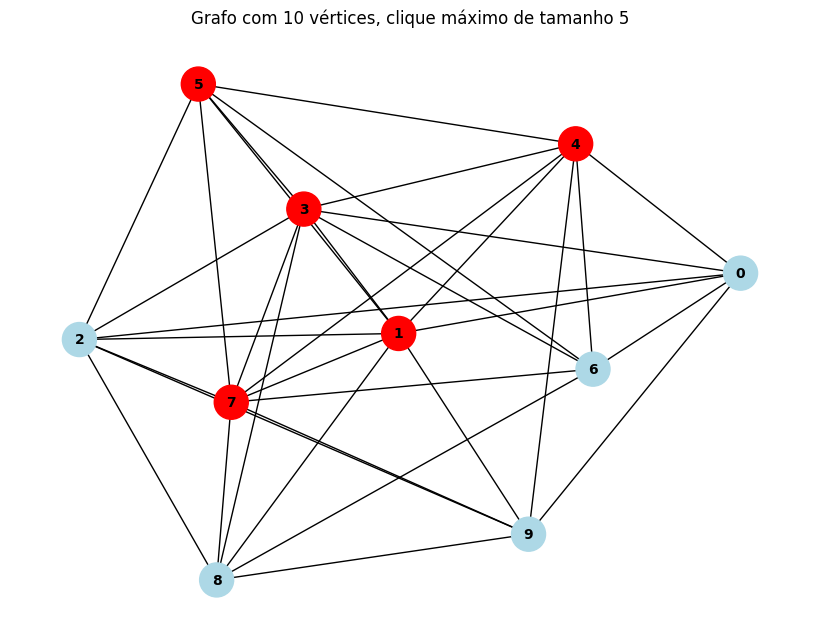

In [ ]:
# QUESTÃO II
# Problema Clique máximo, um grafo aleatório, com 40 vértices e densidade 0.5
# Métodos utilzados: Programação Linear Inteira (PLI), Busca Gulosa, GRASP.

class CliqueMaximo:
    
    @staticmethod
    def criar_grafo_aleatorio(n, densidade=0.5):
        """Cria um grafo aleatório com n vértices e densidade especificada"""
        matriz_adj = np.zeros((n, n))
        for i in range(n):
            for j in range(i+1, n):
                if random.random() < densidade:
                    matriz_adj[i][j] = matriz_adj[j][i] = 1
        return matriz_adj
    
    @staticmethod
    def mostrar_grafo(matriz_adj, vertices_clique=None):
        """Visualiza o grafo e destaca o clique encontrado"""
        G = nx.Graph()
        n = len(matriz_adj)
        
        # Adicionar vértices e arestas
        for i in range(n):
            G.add_node(i)
        
        for i in range(n):
            for j in range(i+1, n):
                if matriz_adj[i][j] > 0:
                    G.add_edge(i, j)
        
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(G, seed=42)
        
        node_colors = ['lightblue' for _ in range(n)]
        if vertices_clique:
            for v in vertices_clique:
                node_colors[v] = 'red'
        
        nx.draw(G, pos, with_labels=True, node_color=node_colors, 
                node_size=600, font_size=10, font_weight='bold')
        
        plt.title(f"Grafo com {n} vértices, clique máximo de tamanho {len(vertices_clique or [])}")
        plt.show()
    
    @staticmethod
    def resolver_pli(matriz_adj):
        """Resolve o problema do clique máximo usando Programação Linear Inteira"""
        n = len(matriz_adj)
        prob = pulp.LpProblem("CliqueMaximo", pulp.LpMaximize)
        
        # Variáveis de decisão: x[i] = 1 se o vértice i está no clique, 0 caso contrário
        x = {i: pulp.LpVariable(f"x_{i}", cat=pulp.LpBinary) for i in range(n)}
        
        # Função objetivo: maximizar o número de vértices no clique
        prob += pulp.lpSum(x[i] for i in range(n))
        
        # Restrições: para cada par de vértices não adjacentes, no máximo um deles pode estar no clique
        for i in range(n):
            for j in range(i+1, n):
                if matriz_adj[i][j] == 0:  # Se não há aresta entre i e j
                    prob += x[i] + x[j] <= 1
        
        # Resolver o modelo
        start_time = time.time()
        prob.solve(pulp.PULP_CBC_CMD(msg=False, timeLimit=30))
        solve_time = time.time() - start_time
        
        # Extrair solução
        vertices_clique = [i for i in range(n) if pulp.value(x[i]) > 0.5]
        
        return {
            'vertices_clique': vertices_clique,
            'tamanho_clique': len(vertices_clique),
            'status': pulp.LpStatus[prob.status],
            'tempo': solve_time
        }
    
    @staticmethod
    def verificar_clique(matriz_adj, vertices):
        """Verifica se um conjunto de vértices forma um clique válido"""
        for i in vertices:
            for j in vertices:
                if i != j and matriz_adj[i][j] == 0:
                    return False
        return True
    
    @staticmethod
    def algoritmo_guloso(matriz_adj):
        """Implementa um algoritmo guloso para o clique máximo"""
        n = len(matriz_adj)
        start_time = time.time()
        
        # Calcular grau de cada vértice
        graus = [sum(matriz_adj[i]) for i in range(n)]
        
        # Ordenar vértices por grau (decrescente)
        vertices_ordenados = sorted(range(n), key=lambda i: graus[i], reverse=True)
        
        melhor_clique = []
        
        # Tentar construir clique a partir de cada vértice
        for v_inicial in vertices_ordenados:
            clique_atual = [v_inicial]
            candidatos = [v for v in range(n) if v != v_inicial and matriz_adj[v_inicial][v] == 1]
            
            while candidatos:
                # Escolher candidato com mais conexões aos vértices já na clique
                melhor_candidato = max(candidatos, 
                                   key=lambda v: sum(matriz_adj[v][u] for u in clique_atual))
                
                clique_atual.append(melhor_candidato)
                
                # Atualizar candidatos para manter apenas vértices conectados a todos no clique
                candidatos = [v for v in candidatos 
                           if v != melhor_candidato and all(matriz_adj[v][u] == 1 for u in clique_atual)]
            
            if len(clique_atual) > len(melhor_clique):
                melhor_clique = clique_atual
        
        solve_time = time.time() - start_time
        
        return {
            'vertices_clique': melhor_clique,
            'tamanho_clique': len(melhor_clique),
            'tempo': solve_time
        }
    
    @staticmethod
    def grasp(matriz_adj, max_iter=50, alpha=0.3):
        """Implementa a metaheurística GRASP para o clique máximo"""
        n = len(matriz_adj)
        start_time = time.time()
        
        melhor_clique = []
        
        for _ in range(max_iter):
            # Fase de construção
            clique = []
            candidatos = list(range(n))
            
            while candidatos:
                # Calcular "atratividade" de cada candidato para adicionar à clique
                atratividade = {}
                for v in candidatos:
                    # Um vértice é atrativo se está conectado a todos os vértices já na clique
                    if all(matriz_adj[v][u] == 1 for u in clique):
                        # Atratividade é proporcional ao número de outros candidatos aos quais está conectado
                        atratividade[v] = sum(matriz_adj[v][c] for c in candidatos if c != v)
                
                if not atratividade:
                    break
                
                # Criar lista restrita de candidatos (RCL)
                valores = list(atratividade.values())
                min_val, max_val = min(valores), max(valores)
                thresh = min_val + alpha * (max_val - min_val)
                rcl = [v for v, val in atratividade.items() if val >= thresh]
                
                # Escolher aleatoriamente da RCL
                escolhido = random.choice(rcl)
                clique.append(escolhido)
                candidatos.remove(escolhido)
                
                # Remover candidatos não conectados ao escolhido
                candidatos = [c for c in candidatos if matriz_adj[escolhido][c] == 1]
            
            # Fase de busca local
            melhorou = True
            while melhorou:
                melhorou = False
                
                # Tentar adicionar mais vértices
                for v in range(n):
                    if v not in clique and all(matriz_adj[v][u] == 1 for u in clique):
                        clique.append(v)
                        melhorou = True
                
                # Tentar trocar vértices
                for v in clique:
                    for u in range(n):
                        if u not in clique:
                            # Remover v e adicionar u
                            clique_teste = [c for c in clique if c != v] + [u]
                            if CliqueMaximo.verificar_clique(matriz_adj, clique_teste) and len(clique_teste) > len(clique):
                                clique = clique_teste
                                melhorou = True
            
            if len(clique) > len(melhor_clique):
                melhor_clique = clique
        
        solve_time = time.time() - start_time
        
        return {
            'vertices_clique': melhor_clique,
            'tamanho_clique': len(melhor_clique),
            'tempo': solve_time
        }

# Params vértices
n = 10
matriz_adj = CliqueMaximo.criar_grafo_aleatorio(n, densidade=0.7)

# Solver PLI
resultado_pli = CliqueMaximo.resolver_pli(matriz_adj)
print("\nResultado PLI:")
print(f"Tamanho do clique: {resultado_pli['tamanho_clique']}")
print(f"Vértices: {resultado_pli['vertices_clique']}")
print(f"Tempo: {resultado_pli['tempo']:.2f} segundos")
print(f"Status: {resultado_pli['status']}")

# Solver Greedy
resultado_guloso = CliqueMaximo.algoritmo_guloso(matriz_adj)
print("\nResultado Algoritmo Guloso:")
print(f"Tamanho do clique: {resultado_guloso['tamanho_clique']}")
print(f"Vértices: {resultado_guloso['vertices_clique']}")
print(f"Tempo: {resultado_guloso['tempo']:.2f} segundos")

# Solver GRASP
resultado_grasp = CliqueMaximo.grasp(matriz_adj)
print("\nResultado GRASP:")
print(f"Tamanho do clique: {resultado_grasp['tamanho_clique']}")
print(f"Vértices: {resultado_grasp['vertices_clique']}")
print(f"Tempo: {resultado_grasp['tempo']:.2f} segundos")

# Visualizar resultados
CliqueMaximo.mostrar_grafo(matriz_adj, resultado_pli['vertices_clique'])

In [ ]:
# QUESTÃO II
# Problema de Rota - Algoritmo A* (com heurística) para encontrar a rota mais curta entre cidades

class City:
    """Representa uma cidade com seus atributos geográficos e demográficos."""
    def __init__(self, data):
        self.codigo = data["codigo"]
        self.municipio = data["municipio"]
        self.latitude = data["latitude"]
        self.longitude = data["longitude"]
        self.populacao = data.get("populacao", float('inf'))
        self.distancia_maceio = data.get("distanciaMaceio", "")
        self.tempo_viagem_maceio = data.get("tempoViagemMaceio", "")
        self.display_id = ""
    
    def __str__(self):
        return f"{self.municipio}"
    
    def __repr__(self):
        return self.__str__()

class RotaPorAStar:
    @staticmethod
    def load_cities(file_path: str) -> List[City]:
        """Carrega as cidades do arquivo JSON"""
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            cities = []
            for i, city_data in enumerate(data):
                if "latitude" in city_data and "longitude" in city_data:
                    city = City(city_data)
                    city.display_id = f"{i:02d}"
                    cities.append(city)
            return cities

    @staticmethod
    def calculate_euclidean_distance(city1: City, city2: City) -> float:
        """Calcula distância euclidiana dos dois pontos"""
        lat_diff = city1.latitude - city2.latitude
        lon_diff = city1.longitude - city2.longitude
        return math.sqrt(lat_diff**2 + lon_diff**2)
    
    @staticmethod
    def find_neighbors(city: City, all_cities: List[City], radius: float) -> List[City]:
        """Encontra as cidades vizinhas dentro do raio"""
        neighbors = []
        for potential_neighbor in all_cities:
            if city.codigo == potential_neighbor.codigo:
                continue
            distance = RotaPorAStar.calculate_euclidean_distance(city, potential_neighbor)
            if distance <= radius:
                neighbors.append(potential_neighbor)
        return neighbors
    
    @staticmethod
    def heuristic(current: City, goal: City) -> float:
        return RotaPorAStar.calculate_euclidean_distance(current, goal)
    
    @staticmethod
    def a_star_search(start_city: City, end_city: City, all_cities: List[City], 
                   radius: float, penalty: float = 0.0) -> Dict:
        """Algoritmo de busca A*"""
        tracemalloc.start()
        start_time = time.time()
        
        g_score = {city.codigo: float('inf') for city in all_cities}  # Custo do caminho do início até o nó
        g_score[start_city.codigo] = 0
        
        f_score = {city.codigo: float('inf') for city in all_cities}  # Estimativa do custo total
        f_score[start_city.codigo] = RotaPorAStar.heuristic(start_city, end_city)
        
        # Para reconstruir o caminho
        previous = {city.codigo: None for city in all_cities}
        
        # Conjunto de nós já visitados
        visited = set()
        nodes_visited = 0
        
        # Fila de prioridade (f_score, contador, cidade)
        pq = [(f_score[start_city.codigo], 0, start_city)]
        counter = 1
        
        while pq:
            _, _, current_city = heapq.heappop(pq)
            
            # Se já visitou, continua
            if current_city.codigo in visited:
                continue
                
            # Marcar como visitado e + 1 contador
            visited.add(current_city.codigo)
            nodes_visited += 1
            
            # Se chegamos ao destino, terminamos
            if current_city.codigo == end_city.codigo:
                break
                
            # Explorar vizinhos
            neighbors = RotaPorAStar.find_neighbors(current_city, all_cities, radius)
            for neighbor in neighbors:
                if neighbor.codigo in visited:
                    continue
                
                # Calcular custo do caminho através deste vizinho
                distance = RotaPorAStar.calculate_euclidean_distance(current_city, neighbor)
                penal = penalty * neighbor.populacao
                tentative_g_score = g_score[current_city.codigo] + distance + penal
                
                # Se encontramos um caminho melhor até este vizinho
                if tentative_g_score < g_score[neighbor.codigo]:
                    previous[neighbor.codigo] = current_city
                    g_score[neighbor.codigo] = tentative_g_score
                    f_score[neighbor.codigo] = tentative_g_score + RotaPorAStar.heuristic(neighbor, end_city)
                    
                    # Adicionar à fila com nova prioridade
                    heapq.heappush(pq, (f_score[neighbor.codigo], counter, neighbor))
                    counter += 1
        
        # Reconstruir o caminho
        path = []
        current = end_city
        if previous[end_city.codigo] is not None or start_city.codigo == end_city.codigo:
            while current:
                path.append(current)
                if current.codigo == start_city.codigo:
                    break
                current = previous[current.codigo]
            path.reverse()
            
        execution_time = time.time() - start_time
        current_memory, peak_memory = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        return {
            "success": len(path) > 0,
            "path": path,
            "distance": g_score[end_city.codigo],
            "execution_time": execution_time,
            "nodes_visited": nodes_visited,
            "memory_usage": peak_memory / 1024
        }

    @staticmethod
    def executar_busca(arquivo_cidades="cities-al.json", origem="maceió", destino="porto calvo", 
                            raio=0.22, penalidade=0.0000005):
        """Executa uma busca A* de exemplo entre duas cidades e exibe os resultados."""
        cities = RotaPorAStar.load_cities(arquivo_cidades)
        
        # Encontrando as cidades de origem e destino
        start_city = next((city for city in cities if city.municipio.lower() == origem.lower()), None)
        end_city = next((city for city in cities if city.municipio.lower() == destino.lower()), None)
        
        if not start_city or not end_city:
            print(f"Erro: Não foi possível encontrar {origem} ou {destino} no arquivo.")
            return None
        
        print(f"Buscando rota de {start_city.municipio} para {end_city.municipio}")
        print("Running A* algorithm...")
        print(f"Raio: {raio} km")
        
        result = RotaPorAStar.a_star_search(start_city, end_city, cities, raio, penalidade)
        
        if result["success"]:
            print("\n- Rota encontrada com A*:")
            path_names = [city.municipio for city in result["path"]]
            print(" → ".join(path_names))
            
            print(f"\nDistância: {result['distance']*111:.2f} km")
            print(f"Cidades no caminho: {len(result['path'])}")
            print(f"Tempo de execução: {result['execution_time']:.4f} segundos")
            print(f"Nós visitados: {result['nodes_visited']}")
        else:
            print("Não foi possível encontrar uma rota com o raio especificado.")
        
        return result

# Main execution
file_path = "cities-al.json"
cities = RotaPorAStar.load_cities(file_path)

# Encontrando Maceió e Porto Calvo
start_city = next((city for city in cities if city.municipio.lower() == "maceió"), None)
end_city = next((city for city in cities if city.municipio.lower() == "porto calvo"), None)
RotaPorAStar.executar_busca()

Buscando rota de Maceió para Porto Calvo
Running A* algorithm...
Raio: 0.22 km

- Rota encontrada com A*:
Maceió → Satuba → Messias → Flexeiras → Joaquim Gomes → Matriz de Camaragibe → Porto Calvo

Distância: 114.24 km
Cidades no caminho: 7
Tempo de execução: 0.0114 segundos
Nós visitados: 11


{'success': True,
 'path': [Maceió,
  Satuba,
  Messias,
  Flexeiras,
  Joaquim Gomes,
  Matriz de Camaragibe,
  Porto Calvo],
 'distance': 1.0291685954289218,
 'execution_time': 0.011363983154296875,
 'nodes_visited': 11,
 'memory_usage': 16.2724609375}